# Feature data only

In [257]:
import pandas as pd
import numpy as np
import os
import seaborn as sb

## Read in the data

In [165]:
player = pd.read_csv('https://raw.githubusercontent.com/jchristo12/fantasy_football/master/data/predictor/player_offense.csv')

In [166]:
#rename columns
player.rename(columns={'seas.1': 'exp'}, inplace=True)

In [167]:
player.columns

Index(['pk', 'gid', 'seas', 'wk', 'player', 'fname', 'lname', 'full_name',
       'team', 'pos1', 'nflid', 'pa', 'pc', 'py', 'ints', 'tdp', 'ra', 'sra',
       'ry', 'tdr', 'fuml', 'trg', 'rec', 'recy', 'tdrec', 'ret', 'rety',
       'tdret', 'exp', 'height', 'weight', 'dob', 'dv', 'forty', 'bench',
       'vertical', 'broad', 'shuttle', 'cone', 'arm', 'hand'],
      dtype='object')

In [168]:
#convert column types to appropriate data types
player = player.astype({'seas': 'category',
          'wk': 'category',
          'team': 'category',
          'pos1': 'category',
          'dv': 'category',
          'exp': 'category'})

## Cumulative Stats

#### Career stats

In [169]:
player_sorted = player.sort_values(by=['player', 'gid'], ascending=True)

In [170]:
player_sorted.head()

,pk,gid,seas,wk,player,fname,lname,full_name,team,pos1,...,dob,dv,forty,bench,vertical,broad,shuttle,cone,arm,hand
74708,3999&AA-0025,3999,2015,1,AA-0025,Ameer,Abdullah,Ameer Abdullah,DET,RB,...,6/13/1993,Big Ten,4.5,24,42.5,130,3.95,6.79,30.0,8.625
74935,4010&AA-0025,4010,2015,2,AA-0025,Ameer,Abdullah,Ameer Abdullah,DET,RB,...,6/13/1993,Big Ten,4.5,24,42.5,130,3.95,6.79,30.0,8.625
75490,4036&AA-0025,4036,2015,3,AA-0025,Ameer,Abdullah,Ameer Abdullah,DET,RB,...,6/13/1993,Big Ten,4.5,24,42.5,130,3.95,6.79,30.0,8.625
75814,4052&AA-0025,4052,2015,4,AA-0025,Ameer,Abdullah,Ameer Abdullah,DET,RB,...,6/13/1993,Big Ten,4.5,24,42.5,130,3.95,6.79,30.0,8.625
76021,4062&AA-0025,4062,2015,5,AA-0025,Ameer,Abdullah,Ameer Abdullah,DET,RB,...,6/13/1993,Big Ten,4.5,24,42.5,130,3.95,6.79,30.0,8.625


In [171]:
player_sorted.loc[:, 'pa':'tdrec'].cumsum().head()

,pa,pc,py,ints,tdp,ra,sra,ry,tdr,fuml,trg,rec,recy,tdrec
74708,0,0,0,0,0,7,4,50,1,0,4,4,44,0
74935,0,0,0,0,0,13,7,59,1,0,5,5,53,0
75490,0,0,0,0,0,21,12,82,1,0,10,7,72,1
75814,0,0,0,0,0,34,17,115,1,0,15,9,83,1
76021,0,0,0,0,0,40,20,131,1,1,17,10,92,1


In [172]:
#initialize a list to hold all cumulative stats
cusum_stats = []

In [173]:
#loop through all unique players and calculate cumulative stats
for i in player_sorted['player'].unique():
    x = player_sorted[player_sorted['player'] == i].loc[:, 'pa':'tdret'].cumsum()
    cusum_stats.append(x)

In [174]:
#combine all of the items in the list into 1 dataframe
cusum_df = pd.concat(cusum_stats, axis=0)

In [175]:
#check to see if length matches the original dataframe
print(cusum_df.shape[0])
print(player.shape[0])

94759
94759


Proof that this method is calculating correctly (lengths match)

In [176]:
#rename columns to add a cusum prefix
cusum_df = cusum_df.add_prefix('cusum_')

In [177]:
#add the cusum data to the sorted data frame
player_sorted_cusum = pd.concat([player_sorted, cusum_df], axis=1)

#### 4-game rolling

In [178]:
#initialize a list to hold each players rolling sum
recent_stats = []

In [179]:
#loop thru each unique player calculating rolling sum
for i in player_sorted['player'].unique():
    x = player_sorted[player_sorted['player'] == i].loc[:, 'pa':'tdret'].rolling(window=4, min_periods=1).sum()
    recent_stats.append(x)

In [180]:
#combine the items in the recent stats list
recent_df = pd.concat(recent_stats, axis=0)

In [181]:
#make sure lengths match the original
print(recent_df.shape[0])
print(player.shape[0])

94759
94759


In [182]:
#rename columns to add a recent prefix
recent_df = recent_df.add_prefix('recent_')

In [183]:
#add the recent stats columns to the sorted data frame
player_rolling_sort = pd.concat([player_sorted_cusum, recent_df], axis=1)

## Add other features

In [184]:
player_rolling_sort.columns

Index(['pk', 'gid', 'seas', 'wk', 'player', 'fname', 'lname', 'full_name',
       'team', 'pos1', 'nflid', 'pa', 'pc', 'py', 'ints', 'tdp', 'ra', 'sra',
       'ry', 'tdr', 'fuml', 'trg', 'rec', 'recy', 'tdrec', 'ret', 'rety',
       'tdret', 'exp', 'height', 'weight', 'dob', 'dv', 'forty', 'bench',
       'vertical', 'broad', 'shuttle', 'cone', 'arm', 'hand', 'cusum_pa',
       'cusum_pc', 'cusum_py', 'cusum_ints', 'cusum_tdp', 'cusum_ra',
       'cusum_sra', 'cusum_ry', 'cusum_tdr', 'cusum_fuml', 'cusum_trg',
       'cusum_rec', 'cusum_recy', 'cusum_tdrec', 'cusum_ret', 'cusum_rety',
       'cusum_tdret', 'recent_pa', 'recent_pc', 'recent_py', 'recent_ints',
       'recent_tdp', 'recent_ra', 'recent_sra', 'recent_ry', 'recent_tdr',
       'recent_fuml', 'recent_trg', 'recent_rec', 'recent_recy',
       'recent_tdrec', 'recent_ret', 'recent_rety', 'recent_tdret'],
      dtype='object')

#### Age

In [185]:
#strip out the year from DOB
dob_year = player_rolling_sort['dob'].apply(lambda x: int(str(x[-4:])))

In [186]:
dob_year.head()

74708    1993
74935    1993
75490    1993
75814    1993
76021    1993
Name: dob, dtype: int64

In [187]:
#add age to dataframe
player_rolling_sort['age'] = player_rolling_sort['seas'].astype(int) - dob_year

In [188]:
player_rolling_sort['age'].head()

74708    22
74935    22
75490    22
75814    22
76021    22
Name: age, dtype: int64

### Passing summaries

#### Career stats

In [189]:
#Passing completion
player_rolling_sort['career_comp_pct'] = player_rolling_sort['cusum_pc'] / player_rolling_sort['cusum_pa']

In [190]:
#touchdown to interception ratio
player_rolling_sort['career_td_to_int'] = player_rolling_sort['cusum_tdp'] / player_rolling_sort['cusum_ints']

In [191]:
#Passing yards per completion
player_rolling_sort['career_yds_per_comp'] = player_rolling_sort['cusum_py'] / player_rolling_sort['cusum_pc']

#### Recent stats

In [192]:
#Passing completion
player_rolling_sort['recent_comp_pct'] = player_rolling_sort['recent_pc'] / player_rolling_sort['recent_pa']

In [193]:
#touchdown to interception ratio
player_rolling_sort['recent_td_to_int'] = player_rolling_sort['recent_tdp'] / player_rolling_sort['recent_ints']

In [194]:
#Passing yards per completion
player_rolling_sort['recent_yds_per_comp'] = player_rolling_sort['recent_py'] / player_rolling_sort['recent_pc']

### Running summaries

#### Career stats

In [195]:
#Yards per rush
player_rolling_sort['career_ryds_per_carry'] = player_rolling_sort['cusum_ry'] / player_rolling_sort['cusum_ra']

In [196]:
#Carries to touchdown ratio
player_rolling_sort['career_carry_to_td'] = player_rolling_sort['cusum_ra'] / player_rolling_sort['cusum_tdr']

In [197]:
#Carries to fumbles lost ratio
player_rolling_sort['career_carry_to_fuml'] = player_rolling_sort['cusum_ra'] / player_rolling_sort['cusum_fuml']

#### Recent stats

In [198]:
#Yards per rush
player_rolling_sort['recent_ryds_per_carry'] = player_rolling_sort['recent_ry'] / player_rolling_sort['recent_ra']

In [199]:
#Carries to touchdown ratio
player_rolling_sort['recent_carry_to_td'] = player_rolling_sort['recent_ra'] / player_rolling_sort['recent_tdr']

In [200]:
#Carries to fumbles lost ratio
player_rolling_sort['recent_carry_to_fuml'] = player_rolling_sort['recent_ra'] / player_rolling_sort['recent_fuml']

### Receiving stats

#### Career stats

In [201]:
#catch percent (catches/targets)
player_rolling_sort['career_catch_pct'] = player_rolling_sort['cusum_rec'] / player_rolling_sort['cusum_trg']

In [202]:
#yards per catch
player_rolling_sort['career_yds_per_rec'] = player_rolling_sort['cusum_recy'] / player_rolling_sort['cusum_rec']

In [203]:
#rec to td's
player_rolling_sort['career_rec_to_td'] = player_rolling_sort['cusum_rec'] / player_rolling_sort['cusum_tdrec']

#### Recent stats

In [204]:
#catch percent (catches/targets)
player_rolling_sort['recent_catch_pct'] = player_rolling_sort['recent_rec'] / player_rolling_sort['recent_trg']

In [205]:
#yards per catch
player_rolling_sort['recent_yds_per_rec'] = player_rolling_sort['recent_recy'] / player_rolling_sort['recent_rec']

In [206]:
#rec to td's
player_rolling_sort['recent_rec_to_td'] = player_rolling_sort['recent_rec'] / player_rolling_sort['recent_tdrec']

### Return stats

#### Career stats

In [207]:
#average return yards
player_rolling_sort['career_avg_ret'] = player_rolling_sort['cusum_rety'] / player_rolling_sort['cusum_ret']

In [208]:
#returns to td's
player_rolling_sort['career_ret_to_td'] = player_rolling_sort['cusum_ret'] / player_rolling_sort['cusum_tdret']

#### Recent stats

In [209]:
#average return yards
player_rolling_sort['recent_avg_ret'] = player_rolling_sort['recent_rety'] / player_rolling_sort['recent_ret']

In [210]:
#returns to td's
player_rolling_sort['recent_ret_to_td'] = player_rolling_sort['recent_ret'] / player_rolling_sort['recent_tdret']

### Final checks

In [211]:
player_rolling_sort.columns

Index(['pk', 'gid', 'seas', 'wk', 'player', 'fname', 'lname', 'full_name',
       'team', 'pos1', 'nflid', 'pa', 'pc', 'py', 'ints', 'tdp', 'ra', 'sra',
       'ry', 'tdr', 'fuml', 'trg', 'rec', 'recy', 'tdrec', 'ret', 'rety',
       'tdret', 'exp', 'height', 'weight', 'dob', 'dv', 'forty', 'bench',
       'vertical', 'broad', 'shuttle', 'cone', 'arm', 'hand', 'cusum_pa',
       'cusum_pc', 'cusum_py', 'cusum_ints', 'cusum_tdp', 'cusum_ra',
       'cusum_sra', 'cusum_ry', 'cusum_tdr', 'cusum_fuml', 'cusum_trg',
       'cusum_rec', 'cusum_recy', 'cusum_tdrec', 'cusum_ret', 'cusum_rety',
       'cusum_tdret', 'recent_pa', 'recent_pc', 'recent_py', 'recent_ints',
       'recent_tdp', 'recent_ra', 'recent_sra', 'recent_ry', 'recent_tdr',
       'recent_fuml', 'recent_trg', 'recent_rec', 'recent_recy',
       'recent_tdrec', 'recent_ret', 'recent_rety', 'recent_tdret', 'age',
       'career_comp_pct', 'career_td_to_int', 'career_yds_per_comp',
       'recent_comp_pct', 'recent_td_to_int', '

In [212]:
#percentage of players that played in more than 4 games
game_thres = 10
sum(player_rolling_sort.groupby(by='player')['gid'].count() > game_thres) / len(player_rolling_sort.groupby(by='player')['gid'].count())

0.5866666666666667

## Game features

### Read in data

In [213]:
game = pd.read_csv('https://raw.githubusercontent.com/jchristo12/fantasy_football/master/data/predictor/game.csv')

In [214]:
#change the data types to the correct format
game = game.astype({'v': 'category',
                   'h': 'category',
                   'day': 'category',
                   'cond': 'category',
                   'stad': 'category',
                   'wdir': 'category',
                   'surf': 'category'})

In [215]:
game.head()

,gid,v,h,day,cond,stad,temp,wdir,surf,humd,ou,sprv,ptsv,ptsh
0,1,SF,ATL,SUN,Dome,Georgia Dome,79.0,NaN,AstroTurf,NaN,42.5,7.0,28,36
1,2,JAC,CLE,SUN,Sunny,Cleveland Browns Stadium,78.0,NE,Grass,63.0,38.0,-10.0,27,7
2,3,PHI,DAL,SUN,Sunny,Texas Stadium,109.0,S,AstroTurf,19.0,40.0,6.0,41,14
3,4,NYJ,GB,SUN,Mostly Cloudy,Lambeau Field,77.0,E,Grass,66.0,36.0,2.5,20,16
4,5,IND,KC,SUN,Mostly Sunny,Arrowhead Stadium,90.0,E,Grass,50.0,44.0,-3.0,27,14


### Feature creation

In [216]:
#add underdog category
game['udog'] = pd.Series(np.where(game['sprv'] > 0, game['v'], game['h']))
game = game.astype({'udog': 'category'})

In [217]:
game.head()

,gid,v,h,day,cond,stad,temp,wdir,surf,humd,ou,sprv,ptsv,ptsh,udog
0,1,SF,ATL,SUN,Dome,Georgia Dome,79.0,NaN,AstroTurf,NaN,42.5,7.0,28,36,SF
1,2,JAC,CLE,SUN,Sunny,Cleveland Browns Stadium,78.0,NE,Grass,63.0,38.0,-10.0,27,7,CLE
2,3,PHI,DAL,SUN,Sunny,Texas Stadium,109.0,S,AstroTurf,19.0,40.0,6.0,41,14,PHI
3,4,NYJ,GB,SUN,Mostly Cloudy,Lambeau Field,77.0,E,Grass,66.0,36.0,2.5,20,16,NYJ
4,5,IND,KC,SUN,Mostly Sunny,Arrowhead Stadium,90.0,E,Grass,50.0,44.0,-3.0,27,14,KC


In [218]:
#count how many times each team has been an underdog
tot_udog = game.groupby(by='udog')['sprv'].count().sort_values(ascending=False)
tot_udog

udog
CLE    242
DET    205
OAK    203
ARI    202
WAS    198
JAC    197
BUF    196
MIA    185
SF     183
CHI    180
NYJ    179
TB     177
CIN    172
HOU    169
CAR    159
KC     156
TEN    155
MIN    153
NYG    152
ATL    150
STL    147
SEA    143
DAL    139
SD     134
BAL    127
NO     121
PHI    115
GB     109
IND    109
DEN    107
PIT     90
NE      71
LA      20
LAC     12
Name: sprv, dtype: int64

In [219]:
#combine game and offensive player data
player_game = player_rolling_sort.merge(game, how='left', on='gid', suffixes=('_poff', '_game'))

In [220]:
player_game.head()

,pk,gid,seas,wk,player,fname,lname,full_name,team,pos1,...,stad,temp,wdir,surf,humd,ou,sprv,ptsv,ptsh,udog
0,3999&AA-0025,3999,2015,1,AA-0025,Ameer,Abdullah,Ameer Abdullah,DET,RB,...,Qualcomm Stadium,84.0,WSW,Grass,47.0,46.0,3.0,28,33,DET
1,4010&AA-0025,4010,2015,2,AA-0025,Ameer,Abdullah,Ameer Abdullah,DET,RB,...,TCF Bank Stadium,67.0,NaN,FieldTurf,NaN,43.5,2.0,16,26,DET
2,4036&AA-0025,4036,2015,3,AA-0025,Ameer,Abdullah,Ameer Abdullah,DET,RB,...,Ford Field,NaN,NaN,FieldTurf,NaN,44.5,-3.0,24,12,DET
3,4052&AA-0025,4052,2015,4,AA-0025,Ameer,Abdullah,Ameer Abdullah,DET,RB,...,CenturyLink Field,74.0,N,FieldTurf,41.0,43.0,10.0,10,13,DET
4,4062&AA-0025,4062,2015,5,AA-0025,Ameer,Abdullah,Ameer Abdullah,DET,RB,...,Ford Field,NaN,NaN,FieldTurf,NaN,44.5,-3.0,42,17,DET


In [221]:
player_game.columns

Index(['pk', 'gid', 'seas', 'wk', 'player', 'fname', 'lname', 'full_name',
       'team', 'pos1',
       ...
       'stad', 'temp', 'wdir', 'surf', 'humd', 'ou', 'sprv', 'ptsv', 'ptsh',
       'udog'],
      dtype='object', length=112)

# Feature and Response variables

### Initial setup

In [222]:
#read in the offensive player response variables
ft_pts = pd.read_csv('https://raw.githubusercontent.com/jchristo12/fantasy_football/master/data/response/offense_final.csv',
                     header=0)

In [223]:
ft_pts.head()

,pk,gid,seas,wk,player,pos1,py,ints,tdp,ry,tdr,recy,tdrec,rety,tdret,fuml,conv,tot_sack,f_pts
0,1&KW-1500,1,2000,1,KW-1500,WR,0,0,0,0,0,0,0,56,0,0,0,0.0,1.60
1,1&CG-0400,1,2000,1,CG-0400,RB,0,0,0,62,0,45,0,0,0,0,0,0.0,10.70
2,1&JG-0600,1,2000,1,JG-0600,QB,252,1,3,22,0,0,0,0,0,0,0,1.0,22.03
3,1&JR-2000,1,2000,1,JR-2000,WR,0,0,0,-2,0,59,0,0,0,0,0,0.0,5.70
4,1&TO-0200,1,2000,1,TO-0200,WR,0,0,0,0,0,72,1,0,0,0,0,0.0,13.20


In [224]:
#trim the columns
response = ft_pts.loc[:, ['pk', 'f_pts']]
response.head()

,pk,f_pts
0,1&KW-1500,1.60
1,1&CG-0400,10.70
2,1&JG-0600,22.03
3,1&JR-2000,5.70
4,1&TO-0200,13.20


### Merge response and feature df's

In [225]:
full_df = player_game.merge(response, on='pk', how='left')
full_df.head()

,pk,gid,seas,wk,player,fname,lname,full_name,team,pos1,...,temp,wdir,surf,humd,ou,sprv,ptsv,ptsh,udog,f_pts
0,3999&AA-0025,3999,2015,1,AA-0025,Ameer,Abdullah,Ameer Abdullah,DET,RB,...,84.0,WSW,Grass,47.0,46.0,3.0,28,33,DET,18.400000
1,4010&AA-0025,4010,2015,2,AA-0025,Ameer,Abdullah,Ameer Abdullah,DET,RB,...,67.0,NaN,FieldTurf,NaN,43.5,2.0,16,26,DET,4.200000
2,4036&AA-0025,4036,2015,3,AA-0025,Ameer,Abdullah,Ameer Abdullah,DET,RB,...,NaN,NaN,FieldTurf,NaN,44.5,-3.0,24,12,DET,10.200000
3,4052&AA-0025,4052,2015,4,AA-0025,Ameer,Abdullah,Ameer Abdullah,DET,RB,...,74.0,N,FieldTurf,41.0,43.0,10.0,10,13,DET,5.942857
4,4062&AA-0025,4062,2015,5,AA-0025,Ameer,Abdullah,Ameer Abdullah,DET,RB,...,NaN,NaN,FieldTurf,NaN,44.5,-3.0,42,17,DET,1.671429


In [226]:
print(full_df.shape)
full_df.columns

(94759, 113)


Index(['pk', 'gid', 'seas', 'wk', 'player', 'fname', 'lname', 'full_name',
       'team', 'pos1',
       ...
       'temp', 'wdir', 'surf', 'humd', 'ou', 'sprv', 'ptsv', 'ptsh', 'udog',
       'f_pts'],
      dtype='object', length=113)

Everything looks good!

## Exploratory Data Analysis

In [281]:
#store positions of interest
pos_of_interest = ['QB', 'RB', 'WR', 'TE']

In [288]:
df_eda = full_df[full_df['pos1'].isin(pos_of_interest)]

In [290]:
#remove observations that don't have NaN for fantasy points
df_eda = df_eda[df_eda['f_pts'].notna()]

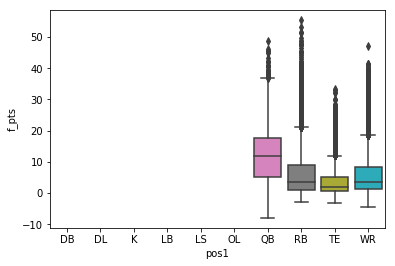

In [291]:
sb.boxplot(x='pos1', y='f_pts', data=df_eda)